# Our Question: What socioeconomic factors contribute most to racial disparities in morbidity from COVID-19? 

### Approach: 
**Taken from previous notebook. Needs to be updated**
- Calculate the total number of COVID cases and deaths per county 
- Merge demographic information about the counties to this dataframe. 

If we have information on covid cases/ethnicity per county...
- Filter the dataset to the counties where there is a disproportiate number of deaths in a certain ethnicity compared to the percentage of that ethnicity in the county. 
- Use propensity scores to weight counties that don't have disparities, but are otherwise comparible, higher. 
- Read more about propensity scores to figure out where to go from there: 
https://www.rand.org/pubs/reprints/RP1252.html


### Data: 
* Cummulative deaths (as well as patients who tested positive and negative for COVID19) per state according to race and ethnicity. Data was downloaded on May 10, 2020 from https://covidtracking.com/race

* Census type data on the overall breakdown of ethnicity and race of states. -- still needed  

* The Surgo Foundation has calculated scores to measure community-level vulnerability during a pandemic. This data was downloaded from https://precisionforcovid.org/ccvi on May 12, 2020. 

The Surgo Foundation's scores are based off of the CDC's Social Vulnerability Index (SVI) https://svi.cdc.gov/. The SVI includes: 
* socioeconomic factors
* household composition & disability
* minority status & language
* housing type & transportation

The SVI, does not however, include underlying health conditions and the state of the community's healthcare system. The score created by Surgo Foundation, and used here, does. To read more about these scores, please visit: https://medium.com/@surgofoundation/why-we-created-a-new-vulnerability-index-specific-to-covid-19-3d88ce1de9ef. 


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

#### Import data on COVID19 cases and deaths - at the state level

In [12]:
ccvi = pd.read_csv('state_ccvi.csv')
ccvi.info()
ccvi.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 9 columns):
State Abbreviation                             51 non-null object
State                                          51 non-null object
THEME 1: Socioeconomic Status                  51 non-null float64
THEME 2:
Household Composition & Disability    51 non-null float64
THEME 3: 
Minority Status & Language           51 non-null float64
THEME 4: 
Housing Type & Transportation        51 non-null float64
THEME 5: Epidemiological Factors               51 non-null float64
THEME 6: Healthcare System Factors             51 non-null float64
CCVI SCORE
Higher = More Vulnerable            51 non-null float64
dtypes: float64(7), object(2)
memory usage: 3.7+ KB


,State Abbreviation,State,THEME 1: Socioeconomic Status,THEME 2: Household Composition & Disability,THEME 3: Minority Status & Language,THEME 4: Housing Type & Transportation,THEME 5: Epidemiological Factors,THEME 6: Healthcare System Factors,CCVI SCORE Higher = More Vulnerable
0,AL,ALABAMA,0.92,0.86,0.42,0.28,0.88,0.96,1.00
1,AK,ALASKA,0.42,0.30,0.60,0.98,0.28,0.10,0.30
2,AZ,ARIZONA,0.70,0.50,0.84,0.56,0.08,0.60,0.50
3,AR,ARKANSAS,0.90,0.98,0.36,0.82,0.84,0.82,0.96
4,CA,CALIFORNIA,0.74,0.20,1.00,0.86,0.02,0.84,0.68


In [13]:
ccvi.columns

Index(['State Abbreviation', 'State', 'THEME 1: Socioeconomic Status',
       'THEME 2:\nHousehold Composition & Disability',
       'THEME 3: \nMinority Status & Language',
       'THEME 4: \nHousing Type & Transportation',
       'THEME 5: Epidemiological Factors',
       'THEME 6: Healthcare System Factors',
       'CCVI SCORE\nHigher = More Vulnerable'],
      dtype='object')

#### Import community-level vulnerability data - county level

In [14]:
deaths = pd.read_csv('Race_data_tracker.csv')
deaths.info()
deaths.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 47 columns):
state                                493 non-null object
Last Check                           234 non-null object
Positives_Total                      348 non-null float64
Positives_race_White                 337 non-null float64
Positives_ race_Black                337 non-null float64
Positives_race_ LatinX _Hispanic     136 non-null float64
Positives_ race_Asian                280 non-null float64
Positives_ race_AIAN                 190 non-null float64
Positives_ race_NHPI                 124 non-null float64
Positives_ race_Multiracial          123 non-null float64
Positives_race_Other                 305 non-null float64
Positives_race_Unknown               337 non-null float64
Positives_race_% Unk.                342 non-null object
Positives_ethnicity_Hispanic         259 non-null float64
Positives_ethnicity_ Non-Hispanic    259 non-null float64
Positives_ethnicity_ Unknown

,state,Last Check,Positives_Total,Positives_race_White,Positives_ race_Black,Positives_race_ LatinX _Hispanic,Positives_ race_Asian,Positives_ race_AIAN,Positives_ race_NHPI,Positives_ race_Multiracial,...,Negatives_race_NHPI,Negatives_race_Multiracial,Negatives_race_Other,Negatives_race_Unknown,Negatives_race_% Unk.,Negatives_ethnicity_ Hispanic,Negatives_ethnicity_Non-Hispanic,Negatives_ethnicity_Unknown,Negatives_ethnicity_% Unk.,Unnamed: 46
0,AK,5/10/2020 22:15,379.0,238.0,9.0,NaN,45.0,24.0,13.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AL,5/10/2020 22:24,9889.0,4333.0,3789.0,NaN,61.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AR,5/10/2020 22:36,4012.0,1922.0,1322.0,NaN,44.0,9.0,53.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AZ,5/10/2020 22:42,11119.0,2631.0,338.0,1889.0,123.0,1278.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
deaths.columns

Index(['state', 'Last Check', 'Positives_Total', 'Positives_race_White ',
       'Positives_ race_Black ', 'Positives_race_ LatinX _Hispanic',
       'Positives_ race_Asian', 'Positives_ race_AIAN', 'Positives_ race_NHPI',
       'Positives_ race_Multiracial ', 'Positives_race_Other',
       'Positives_race_Unknown', 'Positives_race_% Unk.',
       'Positives_ethnicity_Hispanic', 'Positives_ethnicity_ Non-Hispanic',
       'Positives_ethnicity_ Unknown', 'Positives_ethnicity_ % Unk.',
       'Deaths_Total', 'Deaths_race_White ', 'Deaths_race_Black ',
       'Deaths_race_ LatinX_Hispanic', 'Deaths_race_Asian', 'Deaths_race_AIAN',
       'Deaths_race_NHPI', 'Deaths_race_Multiracial ', 'Deaths_race_Other',
       'Deaths_race_Unknown', 'Deaths_race_% Unk.',
       'Deaths_ethnicity_Hispanic', 'Deaths_ethnicity_Non-Hispanic',
       'Deaths_ethnicity_Unknown', 'Deaths_ethnicity_% Unk.',
       'Negatives_race_White ', 'Negatives_race_Black ',
       'Negatives_race_LatinX / Hispanic', 'Neg

Data is collected as cases per day in each county. To get a sum of the cases in each county on the day of downloading data, I grouped the data by fips number. Fips number is found above and can be used to join the 2 datasets. 

In [22]:
deaths_grouped = deaths.groupby(by='state').sum()
deaths_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56 entries, AK to WY
Data columns (total 38 columns):
Positives_Total                      56 non-null float64
Positives_race_White                 56 non-null float64
Positives_ race_Black                56 non-null float64
Positives_race_ LatinX _Hispanic     56 non-null float64
Positives_ race_Asian                56 non-null float64
Positives_ race_AIAN                 56 non-null float64
Positives_ race_NHPI                 56 non-null float64
Positives_ race_Multiracial          56 non-null float64
Positives_race_Other                 56 non-null float64
Positives_race_Unknown               56 non-null float64
Positives_ethnicity_Hispanic         56 non-null float64
Positives_ethnicity_ Non-Hispanic    56 non-null float64
Positives_ethnicity_ Unknown         56 non-null float64
Deaths_Total                         56 non-null float64
Deaths_race_White                    56 non-null float64
Deaths_race_Black                    56 non-nu

In [24]:
deaths_grouped.sort_index()

,Positives_Total,Positives_race_White,Positives_ race_Black,Positives_race_ LatinX _Hispanic,Positives_ race_Asian,Positives_ race_AIAN,Positives_ race_NHPI,Positives_ race_Multiracial,Positives_race_Other,Positives_race_Unknown,...,Negatives_race_LatinX / Hispanic,Negatives_race_Asian,Negatives_race_AIAN,Negatives_race_NHPI,Negatives_race_Multiracial,Negatives_race_Other,Negatives_race_Unknown,Negatives_ethnicity_ Hispanic,Negatives_ethnicity_Non-Hispanic,Negatives_ethnicity_Unknown
state,,,,,,,,,,,,,,,,,,,,,
AK,2390.0,1334.0,49.0,0.0,268.0,128.0,50.0,59.0,52.0,450.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL,48752.0,22233.0,18394.0,0.0,384.0,0.0,0.0,0.0,1334.0,6397.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR,20440.0,10602.0,6225.0,232.0,241.0,26.0,98.0,84.0,619.0,2261.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZ,51376.0,13089.0,1521.0,7698.0,546.0,5679.0,128.0,0.0,825.0,21890.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CA,319537.0,58314.0,13890.0,93222.0,25699.0,429.0,1670.0,2073.0,14266.0,108723.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CO,93443.0,45925.0,6752.0,15250.0,2511.0,454.0,481.0,1155.0,929.0,3566.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CT,177399.0,54531.0,19824.0,26272.0,2428.0,0.0,0.0,0.0,1186.0,75873.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC,29305.0,5027.0,14047.0,0.0,447.0,79.0,80.0,3825.0,1124.0,4414.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
acs = pd.read_csv('ACS_data_cleaned.csv')
acs.info()
acs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 13 columns):
id                                                              52 non-null object
State Name                                                      52 non-null object
State Abbreviation                                              52 non-null object
Total                                                           52 non-null int64
White alone                                                     52 non-null int64
Black or African American alone                                 52 non-null int64
American Indian and Alaska Native alone                         52 non-null int64
Asian alone                                                     52 non-null int64
Native Hawaiian and Other Pacific Islander alone                52 non-null int64
Some other race alone                                           52 non-null int64
Two or more races                                               52 non-nul

,id,State Name,State Abbreviation,Total,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races,Two races including Some other race,"Two races excluding Some other race, and three or more races"
0,0400000US01,Alabama,AL,4887871,3306838,1307040,22063,65095,1797,84027,101011,8348,92663
1,0400000US02,Alaska,AK,737438,474555,25197,111371,46381,7958,9780,62196,3699,58497
2,0400000US04,Arizona,AZ,7171646,5590505,336340,330599,237873,15661,373688,286980,49912,237068
3,0400000US05,Arkansas,AR,3013825,2306096,456714,20951,47548,9398,84917,88201,7476,80725
4,0400000US06,California,CA,39557045,23535388,2283850,302792,5821585,155739,5453229,2004462,440705,1563757


In [26]:
# Weighted distribution of races/ethnicity - CDC data 
wt_dist = pd.read_csv('cdc_weighted_distributions_race.csv')
wt_dist.info()
wt_dist.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 14 columns):
State                                                          28 non-null object
State Abbreviation                                             27 non-null object
%Covid_deaths_Non-Hispanic White                               28 non-null float64
%Covid_deaths_Non-Hispanic Black or African American           28 non-null object
%Covid_deaths_Non-Hispanic American Indian or Alaska Native    28 non-null object
%Covid_deaths_Non-Hispanic Asian                               28 non-null object
%Covid_deaths_Hispanic or Latino                               28 non-null object
%Covid_deaths_Other                                            28 non-null object
%population_Non-Hispanic White                                 28 non-null float64
%population_Non-Hispanic Black or African American             28 non-null float64
%population_Non-Hispanic American Indian or Alaska Native      28 non-null

,State,State Abbreviation,%Covid_deaths_Non-Hispanic White,%Covid_deaths_Non-Hispanic Black or African American,%Covid_deaths_Non-Hispanic American Indian or Alaska Native,%Covid_deaths_Non-Hispanic Asian,%Covid_deaths_Hispanic or Latino,%Covid_deaths_Other,%population_Non-Hispanic White,%population_Non-Hispanic Black or African American,%population_Non-Hispanic American Indian or Alaska Native,%population_Non-Hispanic Asian,%population_Hispanic or Latino,%population_Other
0,United States,NaN,52.1,21.2,0.3,6.1,16.5,3.8,40.4,18.4,0.2,12.1,26.9,1.9
1,Alabama,AL,52.1,44.5,0,-,-,0,56.6,35.7,0.4,2.1,3.8,1.4
2,Arizona,AZ,52.8,-,23.8,-,18.1,-,54.6,5.2,2.1,4.1,31.9,2.2
3,California,CA,40.2,9.6,-,18.3,30.1,1.3,28.3,7.5,0.2,15.1,46.6,2.3
4,Colorado,CO,68.5,7.7,0,4.4,18,-,62.8,6.4,0.5,4.2,23.5,2.6


In [51]:
# this is not elegant 

wt_dist.fillna(0, inplace=True)
wt_dist.replace('-',0,inplace=True)
wt_dist['%Covid_deaths_Non-Hispanic Black or African American'] = wt_dist['%Covid_deaths_Non-Hispanic Black or African American'].astype(float)
wt_dist['%Covid_deaths_Non-Hispanic American Indian or Alaska Native'] = wt_dist['%Covid_deaths_Non-Hispanic American Indian or Alaska Native'].astype(float)
wt_dist['%Covid_deaths_Non-Hispanic Asian'] = wt_dist['%Covid_deaths_Non-Hispanic Asian'].astype(float)
wt_dist['%Covid_deaths_Hispanic or Latino'] = wt_dist['%Covid_deaths_Hispanic or Latino'].astype(float)
wt_dist['%Covid_deaths_Other'] = wt_dist['%Covid_deaths_Other'].astype(float)
wt_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 16 columns):
State                                                          28 non-null object
State Abbreviation                                             28 non-null object
%Covid_deaths_Non-Hispanic White                               28 non-null float64
%Covid_deaths_Non-Hispanic Black or African American           28 non-null float64
%Covid_deaths_Non-Hispanic American Indian or Alaska Native    28 non-null float64
%Covid_deaths_Non-Hispanic Asian                               28 non-null float64
%Covid_deaths_Hispanic or Latino                               28 non-null float64
%Covid_deaths_Other                                            28 non-null float64
%population_Non-Hispanic White                                 28 non-null float64
%population_Non-Hispanic Black or African American             28 non-null float64
%population_Non-Hispanic American Indian or Alaska Native      28 non

In [52]:
wt_dist['disparity_white'] = wt_dist['%Covid_deaths_Non-Hispanic White'] - wt_dist['%population_Non-Hispanic White']
wt_dist['disparity_black'] = wt_dist['%Covid_deaths_Non-Hispanic Black or African American'] - wt_dist['%population_Non-Hispanic Black or African American']
wt_dist['disparity_AIAN'] = wt_dist['%Covid_deaths_Non-Hispanic American Indian or Alaska Native'] - wt_dist['%population_Non-Hispanic American Indian or Alaska Native']
wt_dist['disparity_asian'] = wt_dist['%Covid_deaths_Non-Hispanic Asian'] - wt_dist['%population_Non-Hispanic Asian']
wt_dist['disparity_hispanic'] = wt_dist['%Covid_deaths_Hispanic or Latino'] - wt_dist['%population_Hispanic or Latino']
wt_dist['disparity_other'] = wt_dist['%Covid_deaths_Other'] - wt_dist['%population_Other']
wt_dist.head()

,State,State Abbreviation,%Covid_deaths_Non-Hispanic White,%Covid_deaths_Non-Hispanic Black or African American,%Covid_deaths_Non-Hispanic American Indian or Alaska Native,%Covid_deaths_Non-Hispanic Asian,%Covid_deaths_Hispanic or Latino,%Covid_deaths_Other,%population_Non-Hispanic White,%population_Non-Hispanic Black or African American,%population_Non-Hispanic American Indian or Alaska Native,%population_Non-Hispanic Asian,%population_Hispanic or Latino,%population_Other,disparity_white,disparity_black,disparity_AIAN,disparity_asian,disparity_hispanic,disparity_other
0,United States,0,52.1,21.2,0.3,6.1,16.5,3.8,40.4,18.4,0.2,12.1,26.9,1.9,11.7,2.8,0.1,-6.0,-10.4,1.9
1,Alabama,AL,52.1,44.5,0.0,0.0,0.0,0.0,56.6,35.7,0.4,2.1,3.8,1.4,-4.5,8.8,-0.4,-2.1,-3.8,-1.4
2,Arizona,AZ,52.8,0.0,23.8,0.0,18.1,0.0,54.6,5.2,2.1,4.1,31.9,2.2,-1.8,-5.2,21.7,-4.1,-13.8,-2.2
3,California,CA,40.2,9.6,0.0,18.3,30.1,1.3,28.3,7.5,0.2,15.1,46.6,2.3,11.9,2.1,-0.2,3.2,-16.5,-1.0
4,Colorado,CO,68.5,7.7,0.0,4.4,18.0,0.0,62.8,6.4,0.5,4.2,23.5,2.6,5.7,1.3,-0.5,0.2,-5.5,-2.6


In [53]:
# save dataframe to csv to import in tableau to make a map
wt_dist.to_csv('wt_dist.csv',index=True)

Merge the two datasets together

In [17]:
df = ccvi.join(deaths, on='State', how='left', sort=True)
df.info()
df.head()

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

### Visualize correlations between factors and mortality 

C:\Users\kmuss\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\kmuss\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


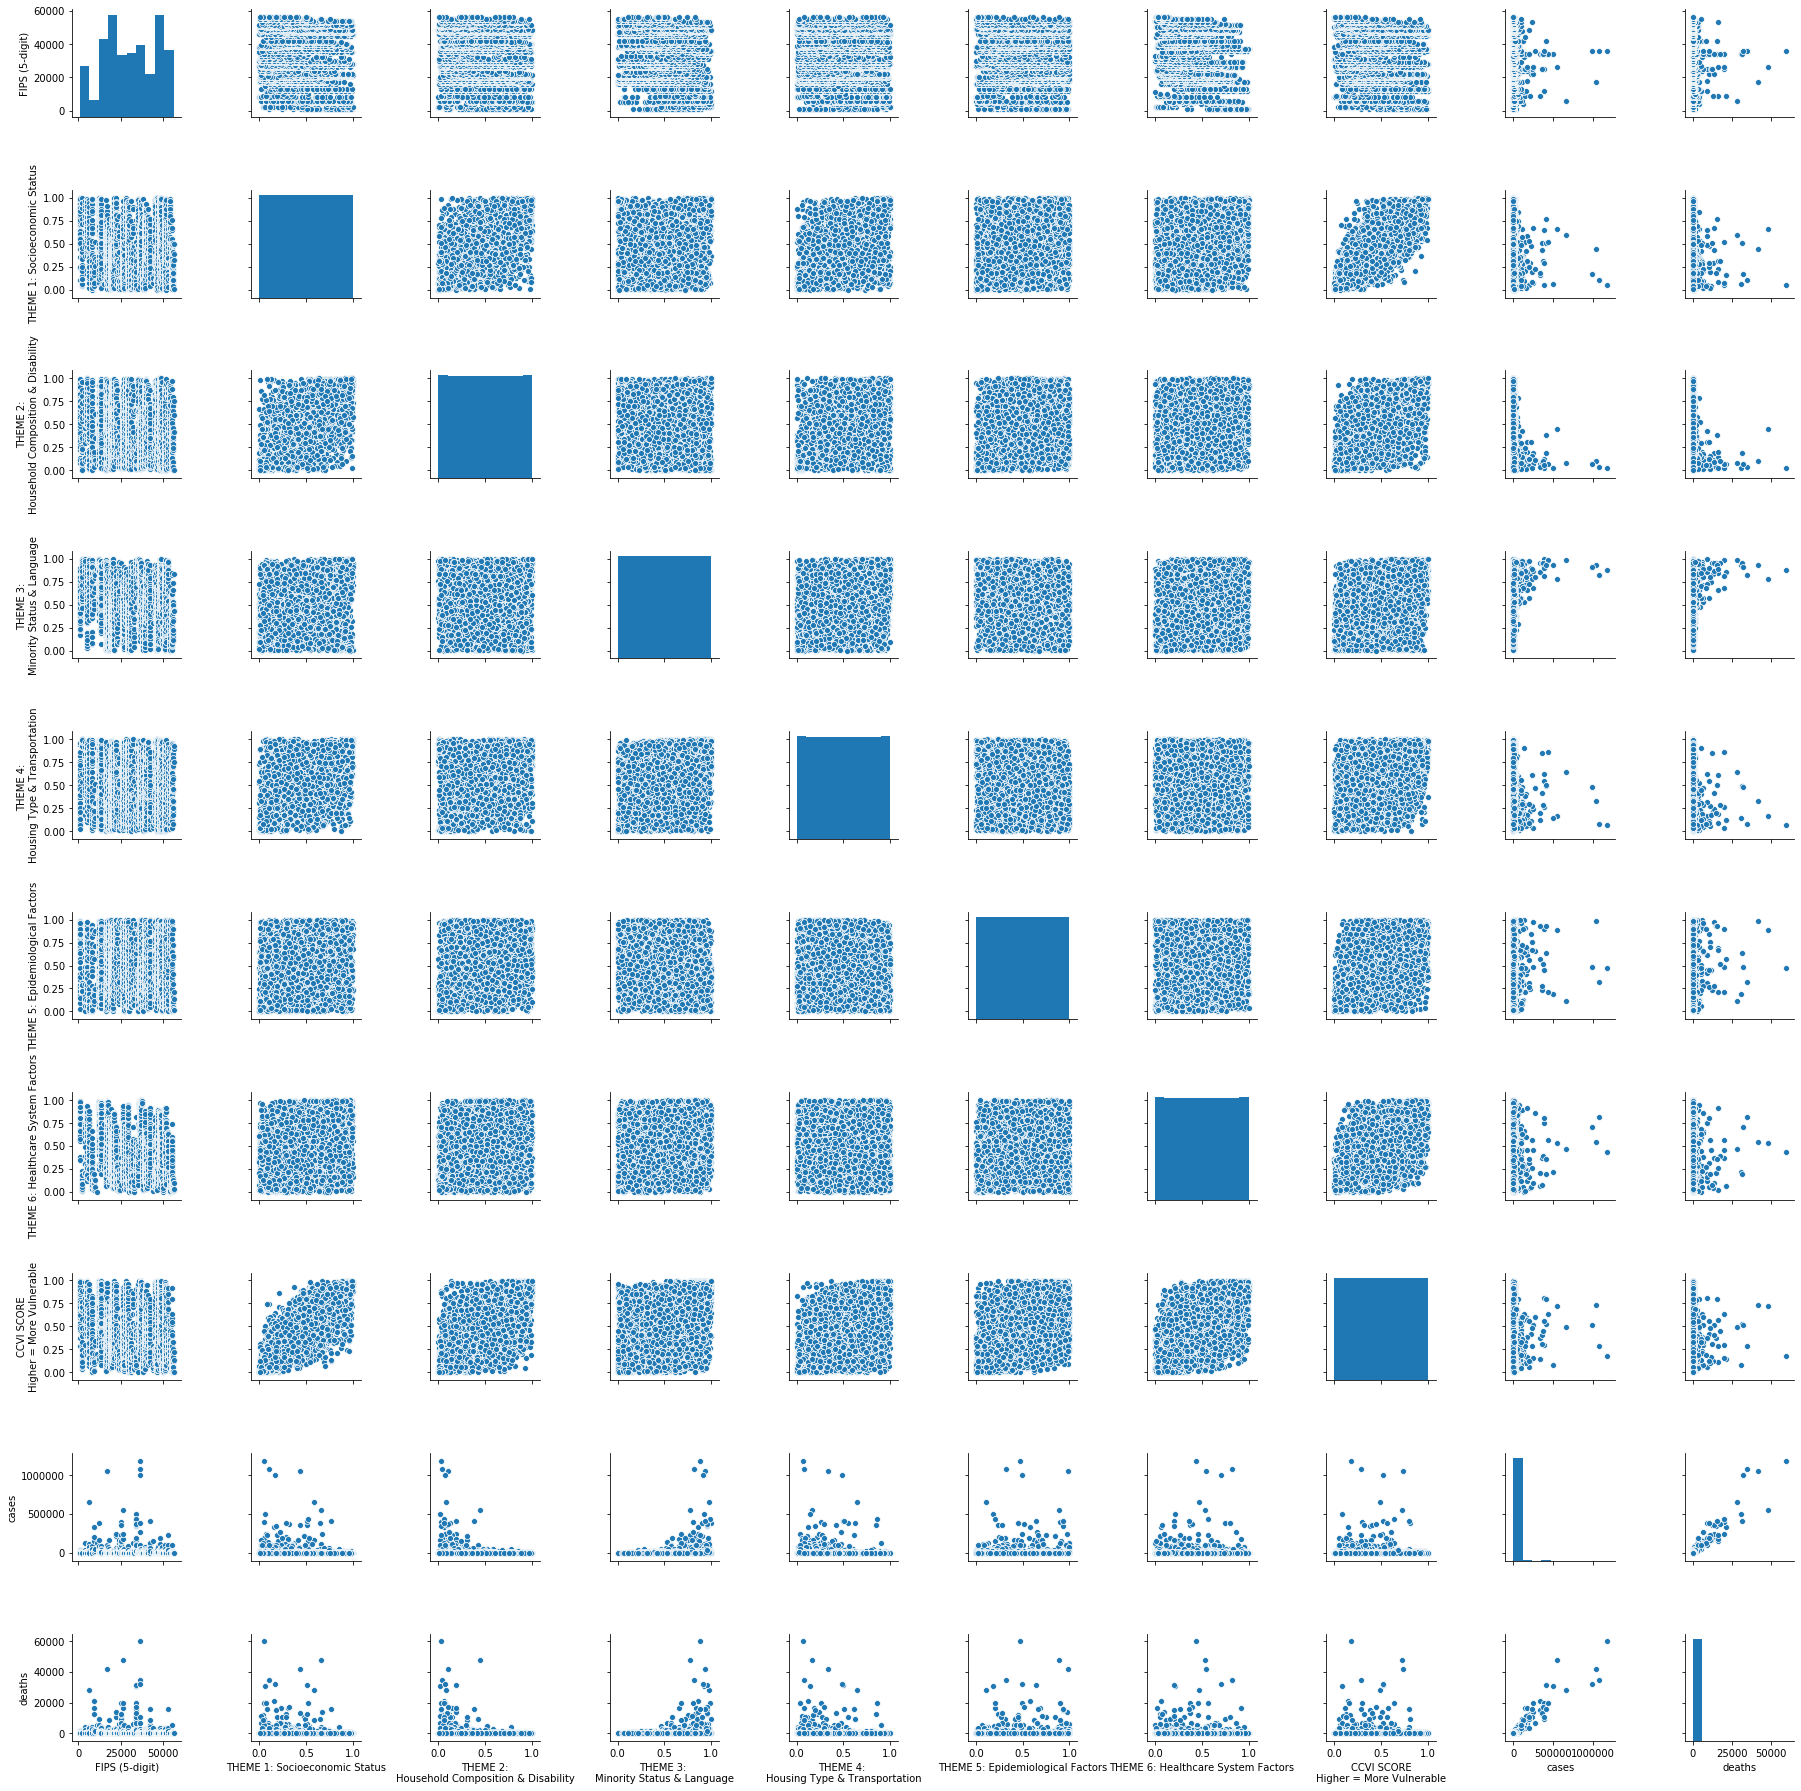

In [21]:
sns.pairplot(df)

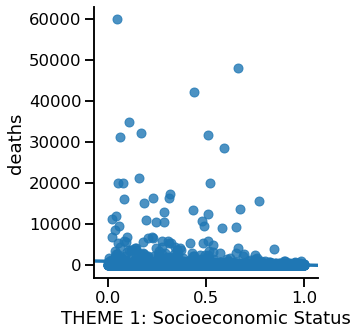

In [36]:
sns.set_context('talk')
sns.lmplot(x='THEME 1: Socioeconomic Status', y='deaths',data=df)

In [24]:
df.columns

Index(['State', 'State Abbreviation', 'County', 'FIPS (5-digit)',
       'THEME 1: Socioeconomic Status',
       'THEME 2:\nHousehold Composition & Disability',
       'THEME 3: \nMinority Status & Language',
       'THEME 4: \nHousing Type & Transportation',
       'THEME 5: Epidemiological Factors',
       'THEME 6: Healthcare System Factors',
       'CCVI SCORE\nHigher = More Vulnerable', 'cases', 'deaths'],
      dtype='object')

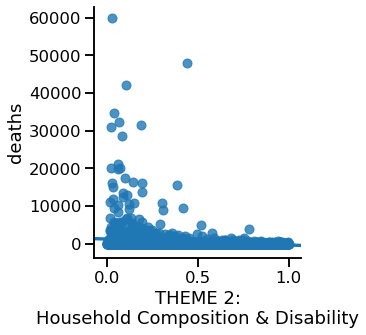

In [37]:
sns.lmplot(x='THEME 2:\nHousehold Composition & Disability', y='deaths',data=df)

#note to rename columns

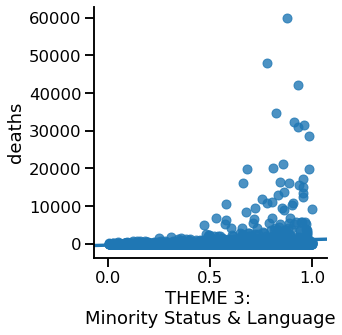

In [38]:
sns.lmplot(x='THEME 3: \nMinority Status & Language', y='deaths',data=df)

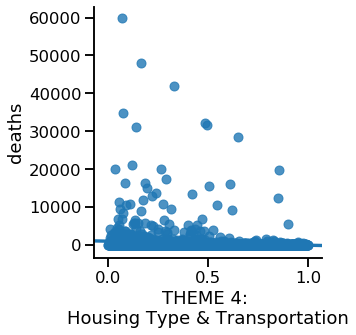

In [39]:
sns.lmplot(x='THEME 4: \nHousing Type & Transportation', y='deaths',data=df)

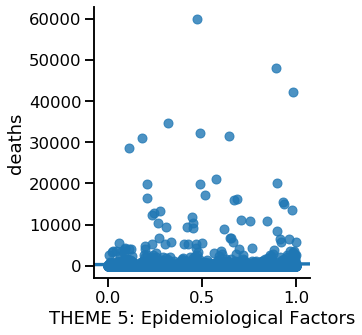

In [40]:
sns.lmplot(x='THEME 5: Epidemiological Factors', y='deaths',data=df)

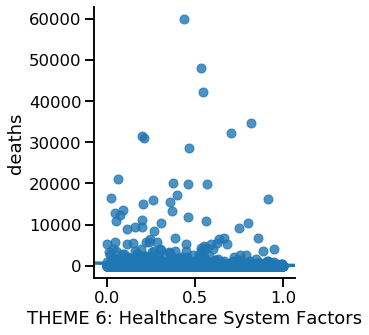

In [41]:
sns.lmplot(x='THEME 6: Healthcare System Factors', y='deaths',data=df)

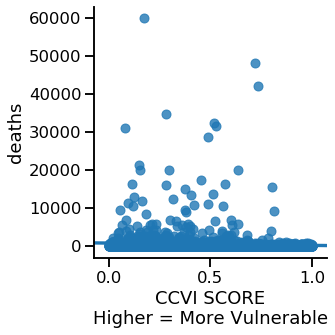

In [42]:
sns.lmplot(x='CCVI SCORE\nHigher = More Vulnerable', y='deaths',data=df)


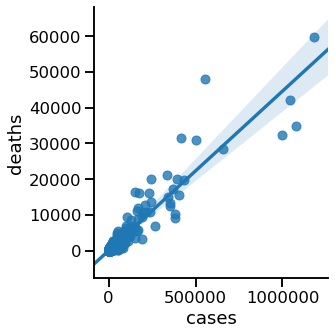

In [43]:
sns.lmplot(x='cases', y='deaths',data=df)


What other data do we need to answer our question? 
* What is the ethnic/racial breakdown of each county? Add these as columns to our dataframe. -- this we could probably get from census data
* What is the percentage of deaths per ethnicity per county? -- this I'm not sure we can get. We can get state level breakdowns of cases by ethnicity for most states (40/50) 

Just looking at Washington, we have state level data- https://www.doh.wa.gov/Emergencies/Coronavirus#CovidDataTables
